In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import pickle

In [54]:
health_data = pd.read_csv("../data/raw/03_health_data.csv")
health_data.head()

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,...,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,...,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,...,2373,19.7,18.6,20.6,3870,4.5,4.2,4.8,887,6
3,1007,22400,2456,10.964286,2596,11.589286,3029,13.522321,3113,13.897321,...,1789,14.1,13.2,14.9,2511,3.3,3.1,3.6,595,2
4,1009,57840,7095,12.266598,7570,13.087828,6742,11.656293,6884,11.901798,...,4661,13.5,12.6,14.5,6017,3.4,3.2,3.7,1507,2


### Analisis del dataframe

In [55]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [56]:
health_data.columns

Index(['fips', 'TOT_POP', '0-9', '0-9 y/o % of total pop', '19-Oct',
       '10-19 y/o % of total pop', '20-29', '20-29 y/o % of total pop',
       '30-39', '30-39 y/o % of total pop',
       ...
       'COPD_number', 'diabetes_prevalence', 'diabetes_Lower 95% CI',
       'diabetes_Upper 95% CI', 'diabetes_number', 'CKD_prevalence',
       'CKD_Lower 95% CI', 'CKD_Upper 95% CI', 'CKD_number',
       'Urban_rural_code'],
      dtype='object', length=108)

In [57]:
health_data.shape

(3140, 108)

In [58]:
health_data.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
fips,3140.0,30401.640764,15150.559265,1001.0,18180.500000,29178.000000,45081.50000,5.604500e+04
TOT_POP,3140.0,104189.412420,333583.395432,88.0,10963.250000,25800.500000,67913.00000,1.010552e+07
0-9,3140.0,12740.302866,41807.301846,0.0,1280.500000,3057.000000,8097.00000,1.208253e+06
0-9 y/o % of total pop,3140.0,11.871051,2.124081,0.0,10.594639,11.802727,12.95184,2.546068e+01
19-Oct,3140.0,13367.976752,42284.392134,0.0,1374.500000,3274.000000,8822.25000,1.239139e+06


In [59]:
health_data.duplicated().sum()

np.int64(0)

## Analisis de variables

En este proyecto vamos a intentar analizar si existe alguna relación entre los recursos sanitarios disponibles (por ejemplo, médicos por habitante, número de hospitales o camas UCI) y una serie de características sociodemográficas de los condados de Estados Unidos.

El dataset con el que trabajo es bastante amplio, 108 columnas, e incluye información sobre población por edades, nivel de pobreza, renta, educación, situación laboral, ruralidad, y distintos tipos de personal sanitario o infraestructura médica.

Para no perderme entre tantas variables, lo primero que he hecho ha sido agrupar la información por bloques temáticos (demografía, economía, recursos sanitarios, etc.) y quedarme solo con las columnas que realmente ayudan a responder la pregunta principal del análisis.

Mi objetivo es ver si ciertos factores sociodemográficos, como la pobreza, la ruralidad o la edad de la población, están relacionados con una mayor o menor disponibilidad de recursos sanitarios. Para ello:

Haré un análisis exploratorio general.

Examinaré correlaciones entre variables.

Construiré varios modelos de regresión (lineal, Ridge, Lasso, ElasticNet).

Compararé sus resultados y sacaré conclusiones.

### Seleccionamos las variables relevantes
No todas son necesarias para responder la pregunta planteada. Mi objetivo es estudiar si existe relación entre determinados recursos sanitarios y algunas características sociodemográficas de los condados, así que lo primero ha sido intentar organizar todas las variables en bloques temáticos.

Después de revisar la definición de variables y los nombres de todas las columnas, identifiqué cuatro grupos principales:

1. Variables demográficas

Incluyen la distribución de población por edades y la población total.

2. Variables socioeconómicas

Renta, pobreza, educación y empleo.
Son factores que pueden influir en el acceso y la disponibilidad de recursos sanitarios.

3. Variables sanitarias

Miden la capacidad real del sistema de salud:
número de médicos por habitante, especialistas, enfermeras, hospitales, camas UCI, etc.

4. Variables geográficas

Como el código urbano–rural, que clasifica el condado según su nivel de urbanización.

 ¿Qué columnas he seleccionado?

Para este análisis, quiero evitar ruido y centrarme en variables que tengan un papel claro en el problema. Por eso he elegido:

 Recursos sanitarios:

* Active Physicians per 100000 Population (2018)

* Total Active Patient Care Physicians per 100000 Population

* Active Primary Care Physicians

* Active General Surgeons

* Total nurse practitioners

* Total physician assistants

* Total Hospitals

* ICU Beds_x

Estas variables representan directamente la infraestructura y el personal sanitario.

 Datos sociodemográficos:

* TOT_POP (población total)

* Percent of Population Aged 60+ (envejecimiento)

* PCTPOVALL_2018 (pobreza)

* MEDHHINC_2018 (renta)

* Unemployment_rate_2018 (paro)

* Urban_rural_code (grado de urbanización)

Estos factores son los que más probablemente expliquen por qué algunos condados disponen de más recursos sanitarios que otros.

 ¿Por qué descarto el resto?

**Variables duplicadas** (Total Population, POP_ESTIMATE_2018…).

**Columnas de intervalo de confianza (CI)**, que no aportan valor al modelo.

**Prevalencia de enfermedades** (diabetes, CKD, COPD…), porque no son sociodemográficas.

**Columnas textuales** (COUNTY_NAME, STATE_NAME).

Variables de raza, educación detallada y otros indicadores demasiado específicos que no necesito para este objetivo concreto.

Mi idea es simplificar el modelo lo máximo posible sin perder información relevante.



In [60]:
#Recursos sanitarios
health_resources = [
    'Active Physicians per 100000 Population 2018 (AAMC)',
    'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
    'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
    'Active General Surgeons per 100000 Population 2018 (AAMC)',
    'Total nurse practitioners (2019)',
    'Total physician assistants (2019)',
    'Total Hospitals (2019)',
    'ICU Beds_x'
]
#Datos sociodemograficos
sociodemographics = [
    'TOT_POP',
    'Percent of Population Aged 60+',
    'PCTPOVALL_2018',
    'MEDHHINC_2018',
    'Unemployment_rate_2018',
    'Urban_rural_code'
]


### Heatmap para ver si hay relación

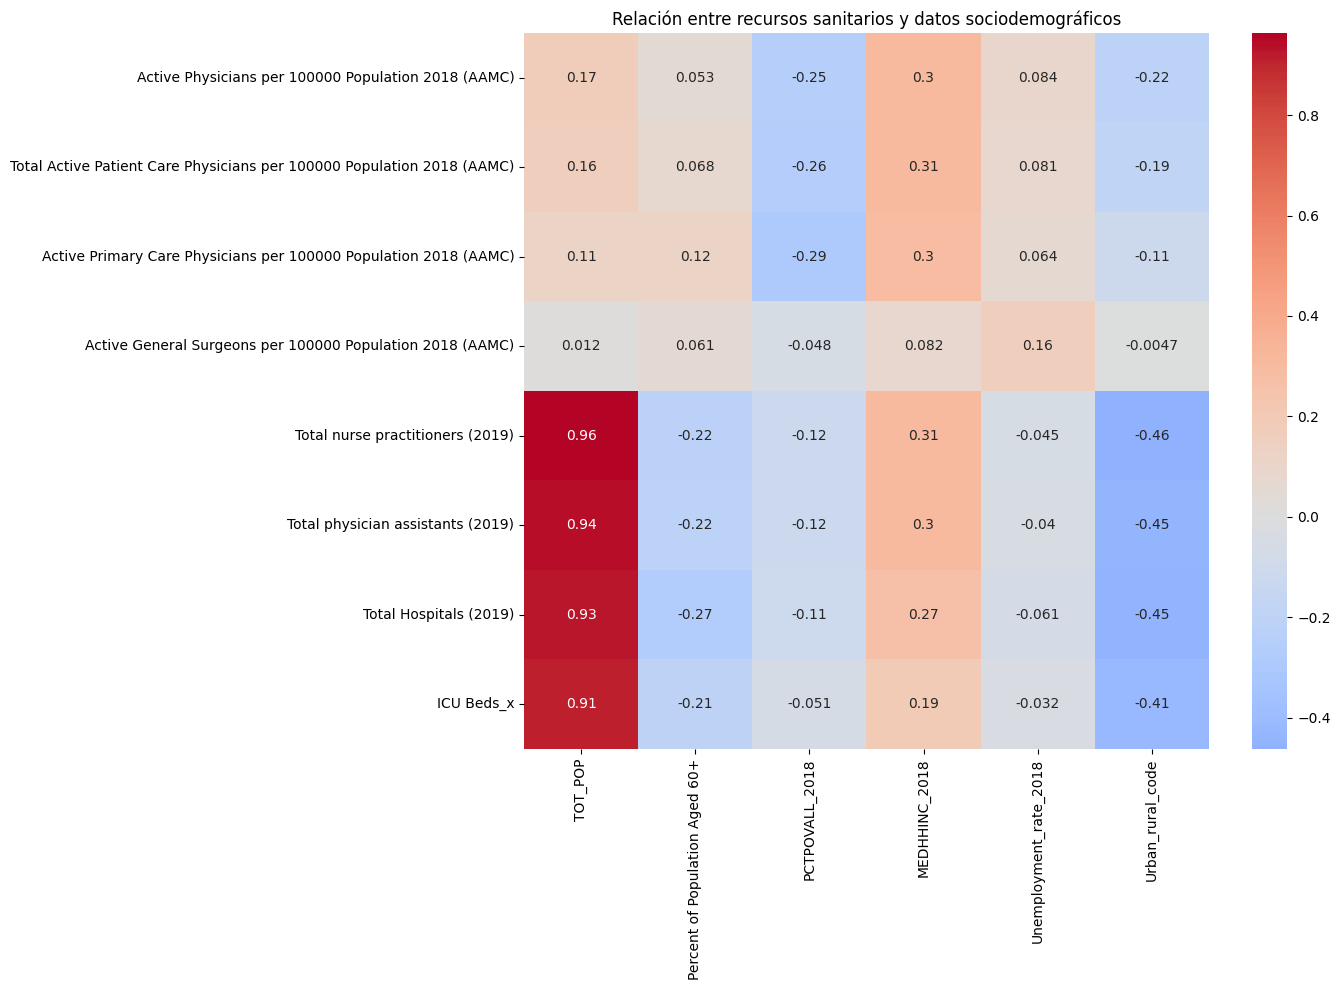

In [61]:
cross = health_data[health_resources + sociodemographics].corr()

plt.figure(figsize=(14,10))
sns.heatmap(cross.loc[health_resources, sociodemographics],
            annot=True, cmap='coolwarm', center=0)
plt.title("Relación entre recursos sanitarios y datos sociodemográficos")
plt.tight_layout()
plt.show()


Podemos ver:


*   Correlación positiva entre población total y número de hospitales
*   Correlación negativa entre ruralidad (códigos más altos) y número de médicos

*   Correlación positiva entre renta (income) y recursos sanitarios

    

### Riqueza vs recursos sanitarios

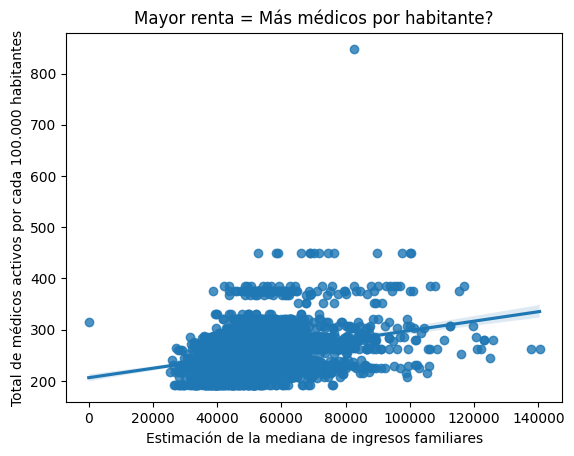

In [62]:
sns.regplot(data=health_data, x='MEDHHINC_2018', y='Active Physicians per 100000 Population 2018 (AAMC)')

plt.title("Mayor renta = Más médicos por habitante?")
plt.xlabel("Estimación de la mediana de ingresos familiares")
plt.ylabel("Total de médicos activos por cada 100.000 habitantes")

plt.show()


### Pobreza vs recursos sanitarios

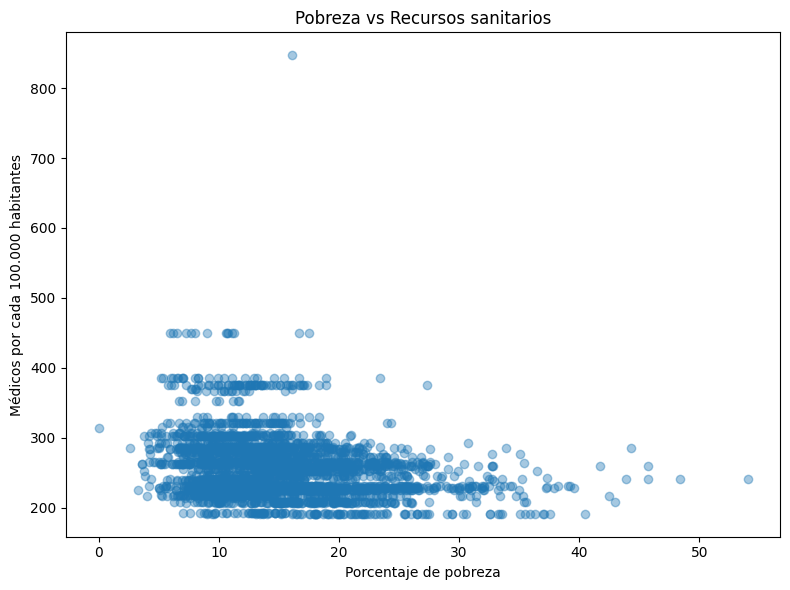

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(
    health_data['PCTPOVALL_2018'],
    health_data['Active Physicians per 100000 Population 2018 (AAMC)'],
    alpha=0.4
)
plt.xlabel("Porcentaje de pobreza")
plt.ylabel("Médicos por cada 100.000 habitantes")
plt.title("Pobreza vs Recursos sanitarios")
plt.tight_layout()
plt.show()

Los condados con niveles de pobreza más elevados concentran valores más bajos de recursos sanitarios, lo que coincide con las desigualdades territoriales en salud.

Este gráfico conecta directamente condiciones socioeconómicas con recursos sanitarios disponibles.

### Renta vs Pobreza

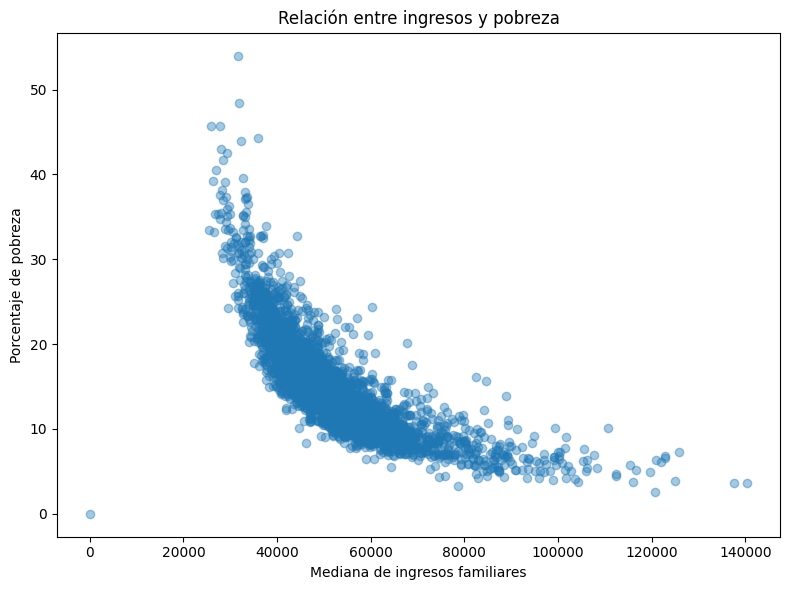

In [64]:
plt.figure(figsize=(8, 6))
plt.scatter(
    health_data['MEDHHINC_2018'],
    health_data['PCTPOVALL_2018'],
    alpha=0.4
)
plt.xlabel("Mediana de ingresos familiares")
plt.ylabel("Porcentaje de pobreza")
plt.title("Relación entre ingresos y pobreza")
plt.tight_layout()
plt.show()


Este gráfico muestra cómo se relacionan la mediana de ingresos familiares (MEDHHINC_2018) y el porcentaje de pobreza (PCTPOVALL_2018).
La relación es claramente inversa y no lineal: a medida que aumenta la renta del condado, el nivel de pobreza disminuye de manera pronunciada.

Este patrón confirma que los condados con mejores condiciones socioeconómicas tienden a ofrecer un entorno más favorable, lo cual puede influir directamente en la disponibilidad de recursos sanitarios.
La estructura socioeconómica es desigual entre condados, y esto probablemente repercute en los recursos sanitarios.

### Ruralidad (urban_rural_code) vs recursos

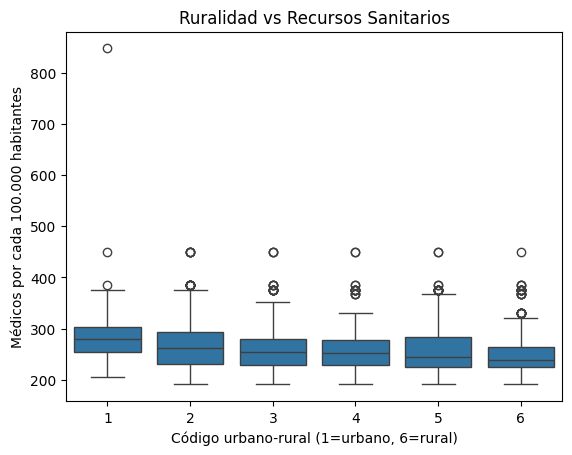

In [65]:
sns.boxplot(data=health_data,
            x='Urban_rural_code',
            y='Active Physicians per 100000 Population 2018 (AAMC)')

plt.title("Ruralidad vs Recursos Sanitarios")
plt.xlabel("Código urbano-rural (1=urbano, 6=rural)")
plt.ylabel("Médicos por cada 100.000 habitantes")

plt.show()

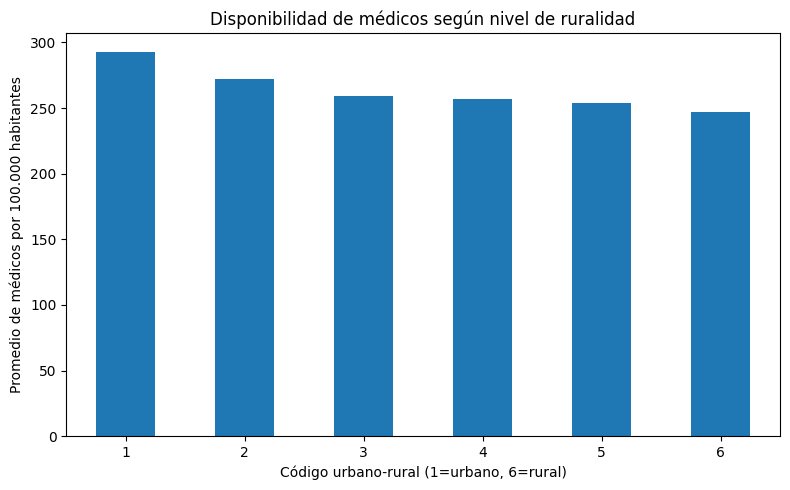

In [66]:
grouped = health_data.groupby('Urban_rural_code')['Active Physicians per 100000 Population 2018 (AAMC)'].mean()

plt.figure(figsize=(8, 5))

grouped.plot(kind='bar')

plt.xlabel("Código urbano-rural (1=urbano, 6=rural)")
plt.ylabel("Promedio de médicos por 100.000 habitantes")
plt.title("Disponibilidad de médicos según nivel de ruralidad")

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [67]:
health_data.sort_values(
    by='Active Physicians per 100000 Population 2018 (AAMC)',
    ascending=False
).head(5)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,...,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
317,11001,702455,83239,11.849727,65473,9.320597,136020,19.363518,143203,20.386075,...,28049,8.1,7.5,8.7,46523,2.6,2.5,2.7,14899,1
1228,25027,830839,92020,11.075551,106944,12.871808,110616,13.313771,105527,12.701257,...,39053,9.4,8.6,10.2,61478,2.7,2.5,2.9,17828,3
1215,25001,213413,16278,7.627464,19901,9.325111,20798,9.745423,18809,8.813427,...,13144,10.5,9.3,11.6,18954,3.3,3.1,3.6,6034,4
1218,25007,17352,1664,9.589673,1667,9.606962,1710,9.854772,1971,11.358921,...,946,10.1,9.1,11.0,1439,3.0,2.8,3.3,435,5
1220,25011,70963,6497,9.155475,7169,10.102448,7832,11.036737,8662,12.206361,...,4292,10.0,8.9,11.0,5833,3.1,2.9,3.4,1811,5


In [68]:
health_data[health_data["fips"] == 11001][["fips", "COUNTY_NAME", "STATE_NAME"]]


,fips,COUNTY_NAME,STATE_NAME
317,11001,District of Columbia,District of Columbia


El boxplot muestra un outlier muy elevado en el nivel urbano más alto (código 1).
Este valor corresponde al condado FIPS 11001 (Washington D.C.), que presenta una ratio excepcionalmente alta de médicos por cada 100.000 habitantes.

Esto no es un error de datos, el distrito de Columbia concentra numerosos hospitales federales, centros universitarios y complejos clínicos especializados, mientras que su población residente es relativamente reducida.

En consecuencia, la tasa de médicos por habitante es muy superior a la del resto del país. Este valor lo mantendré en el dataset porque representa un fenómeno real, aunque es importante interpretarlo como una característica propia de zonas urbanas muy especializadas.Los condados altamente urbanos concentran grandes complejos hospitalarios, lo que genera ratios extremadamente altos de médicos por habitante. Aunque aparece como outlier en el boxplot, no es un error, sino un patrón urbano real.

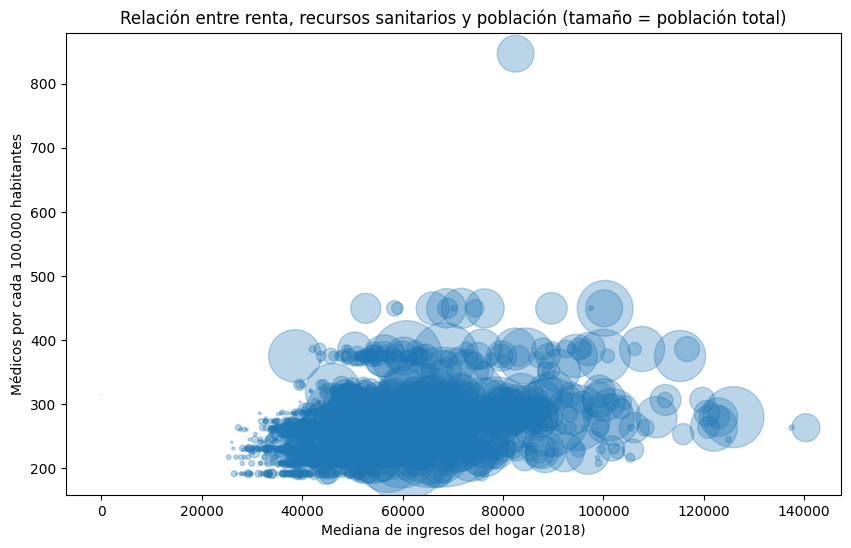

In [69]:
plt.figure(figsize=(10, 6))
plt.scatter(health_data['MEDHHINC_2018'],
            health_data['Active Physicians per 100000 Population 2018 (AAMC)'],
            # tamaño proporcional
            s=health_data['TOT_POP'] / 1000,
            alpha=0.3)
plt.xlabel("Mediana de ingresos del hogar (2018)")
plt.ylabel("Médicos por cada 100.000 habitantes")
plt.title("Relación entre renta, recursos sanitarios y población (tamaño = población total)")
plt.show()


## Conclusión

Estos gráficos revelan un patrón coherente:
* Los condados con mayor renta presentan menor pobreza.
 * Los condados con mayor pobreza tienen menos recursos sanitarios.
* Los ingresos más altos se asocian con mayor disponibilidad de médicos.
* Dependiendo de la ruralidad hay diferencia de disponibilidad de recursos sanitarios

Las condiciones sociodemográficas están estrechamente ligadas a la distribución de los recursos sanitarios en EE.UU.
Este patrón confirma que las desigualdades socioeconómicas realmente influyen en la capacidad sanitaria disponible por condado

## Ingeniería de caracterísiticas

Creamos una nueva caracteristica logaritmica, log_TOT_POP, para hcerla más lineal, ya que la población esta muy sesgada (condados con poblaciones muy dispares) y ya que aporta beneficios al modelo. Queremos predecir los médicos por habitantes, asi que nuestro target será 'Active Physicians per 100000 Population 2018 (AAMC)'

In [70]:
# Partimos de health_data ya cargado
df = health_data.copy()

# Nueva caracteristica: logaritmo de la población total
df['log_TOT_POP'] = np.log1p(df['TOT_POP'])

# Definimos columnas de modelo
y_col = 'Active Physicians per 100000 Population 2018 (AAMC)'

X_cols = [
    'log_TOT_POP',
    'Percent of Population Aged 60+',
    'PCTPOVALL_2018',
    'MEDHHINC_2018',
    'Unemployment_rate_2018',
    'Urban_rural_code'
]

# Dataset solo con lo que necesitamos, sin nulos y guardado
df_model = df[X_cols + [y_col]].dropna()
df_model.to_csv("../data/processed/03_health_data_processed.csv", index=False)



### Train, Test split y escalado

In [71]:
#train test split
X = df_model[X_cols]
y = df_model[y_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modelos Lineal, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet

In [72]:
models = {}

#Regresión lineal
models['Linear'] = LinearRegression()

#Ridge
models['Ridge'] = Ridge(alpha=1.0)

#RidgeCV (selecciona alpha óptimo)
models['RidgeCV'] = RidgeCV(alphas=[0.1, 1, 10, 100])

#Lasso
models['Lasso'] = Lasso(alpha=0.1)

#LassoCV
models['LassoCV'] = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)

#ElasticNet
models['ElasticNet'] = ElasticNet(alpha=0.1, l1_ratio=0.5)

results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Modelo': name,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='R2', ascending=False)

results_df


,Modelo,MSE,RMSE,R2
0,Linear,1270.123407,35.638791,0.226121
1,Ridge,1270.066375,35.637991,0.226156
2,RidgeCV,1269.573437,35.631074,0.226456
3,Lasso,1268.961961,35.622492,0.226829
4,LassoCV,1269.994108,35.636977,0.226200
5,ElasticNet,1265.790493,35.577950,0.228761


### Analisis evolución del R2 cuando el hiperparámetro del modelo Lasso cambia




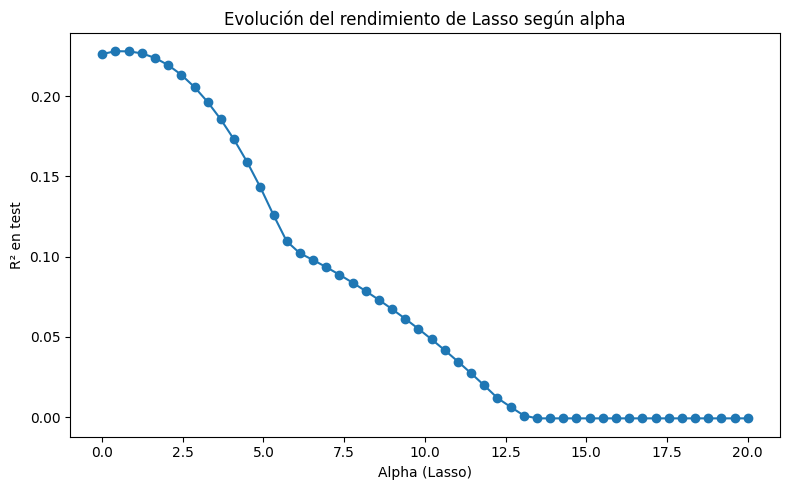

In [73]:
alphas = np.linspace(0.01, 20, 50)
r2_scores = []

for a in alphas:
    lasso_tmp = Lasso(alpha=a, max_iter=10000)
    lasso_tmp.fit(X_train_scaled, y_train)
    y_pred = lasso_tmp.predict(X_test_scaled)
    r2_scores.append(r2_score(y_test, y_pred))

plt.figure(figsize=(8, 5))
plt.plot(alphas, r2_scores, marker='o')
plt.xlabel("Alpha (Lasso)")
plt.ylabel("R² en test")
plt.title("Evolución del rendimiento de Lasso según alpha")
plt.tight_layout()
plt.show()


### Guardar con pickle

In [74]:
import pickle

to_save = {
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler,
    'X_cols': X_cols,
    'y_col': y_col
}

with open('../data/processed/03_health_processed.pkl', 'wb') as f:
    pickle.dump(to_save, f)



# Conclusión general e interpretación

Los modelos de regresión lineal y regularización (Lasso, Ridge y ElasticNet) muestran que las variables sociodemográficas seleccionadas explican alrededor del 22–23% de la disponibilidad de médicos por habitante en los condados analizados.

Este resultado indica que existe una relación entre factores como la renta, la pobreza o la ruralidad y la distribución de recursos sanitarios, pero también que gran parte de la variabilidad depende de factores estructurales que no están incluidos en el dataset (políticas sanitarias, presencia de universidades médicas, especialización hospitalaria, financiación estatal, etc.).

El mejor rendimiento lo obtiene el modelo ElasticNet, aunque solo con una mejora marginal respecto al resto. Esto da la idea de que no existe una única variable dominante, sino un conjunto de factores que contribuyen parcialmente al acceso sanitario.

El rendimiento de los modelos de regresión (R2 ≈ 0.22–0.23) indica que las variables sociodemográficas consideradas explican aproximadamente un 22% de la variabilidad en la disponibilidad de médicos por habitante.

Este valor es totalmente coherente con este tipo de análisis, ya que la distribución de recursos sanitarios está condicionada por muchos factores estructurales que no aparecen en este dataset (historia de inversión, infraestructura hospitalaria, presencia de universidades médicas, políticas estatales, redes clínicas especializadas, etc.).

La sociodemografía influye parcialmente, pero no determina completamente la oferta médica. Por ello, un R2 alrededor del 20–30%.

Como el objetivo del estudio no es maximizar la capacidad predictiva absoluta, sino evaluar si existe relación entre variables sociodemográficas y recursos sanitarios, algo que los modelos confirman.